### Updates of the Previous Notebook

1. Algorithms like Xgboost can take care of Categorical and 
   Ordinal features without OneHotEncoding. So as per our features, performing
   OneHotEncoding results in more features and Curse of Dimensionality begins !!
2. Cross Validation using StratifiedKFold

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('Dataset/train.csv')
df_test = pd.read_csv('Dataset/test.csv')
df_train.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [3]:
df_train.shape,df_test.shape

((18834, 11), (8072, 9))

In [4]:
labels = df_train.iloc[:,-2:]
id_test = df_test['pet_id']
df_train = df_train.drop(['breed_category','pet_category'],axis=1)

In [5]:
df_all = pd.concat([df_train,df_test],axis=0,ignore_index=True)

In [6]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total/len(df)*100
    df = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
    df = df[df['Percent']!=0]
    return df.sort_values(by='Percent',ascending=False)

In [7]:
missing_percentage(df_all)

,Total,Percent
condition,2096,7.790084


In [8]:
df_all['issue_date'] = df_all['issue_date'].apply(lambda x:x.split(' ')[0])

df_all['isd_date'] = df_all['issue_date'].apply(lambda x:x.split('-')[2])
df_all['isd_month'] = df_all['issue_date'].apply(lambda x:x.split('-')[1])
df_all['isd_year'] = df_all['issue_date'].apply(lambda x:x.split('-')[0])

df_all.drop('issue_date',axis=1,inplace=True)

In [9]:
df_all['list_date'] = df_all['listing_date'].apply(lambda x:x.split(' ')[0])
df_all['list_time'] = df_all['listing_date'].apply(lambda x:x.split(' ')[1])

df_all.drop('listing_date',axis=1,inplace=True)

In [10]:
df_all['lst_date'] = df_all['list_date'].apply(lambda x:x.split('-')[2])
df_all['lst_month'] = df_all['list_date'].apply(lambda x:x.split('-')[1])
df_all['lst_year'] = df_all['list_date'].apply(lambda x:x.split('-')[0])
df_all = df_all.drop('list_date',axis=1)

df_all = df_all.drop(['list_time','pet_id'],axis=1)

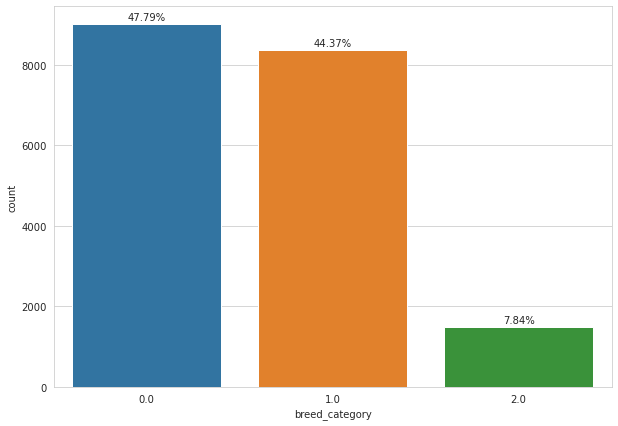

In [11]:
sns.set_style('whitegrid')

order1 = labels['breed_category'].value_counts()
order2 = order1.index
plt.figure(figsize=(10,7))
sns.countplot(labels['breed_category'],order=order2)

for i in range(order1.shape[0]):
    count = order1[i]
    strg = '{:0.2f}%'.format(100*count/labels.shape[0])
    plt.text(i,count+100,strg,ha='center')

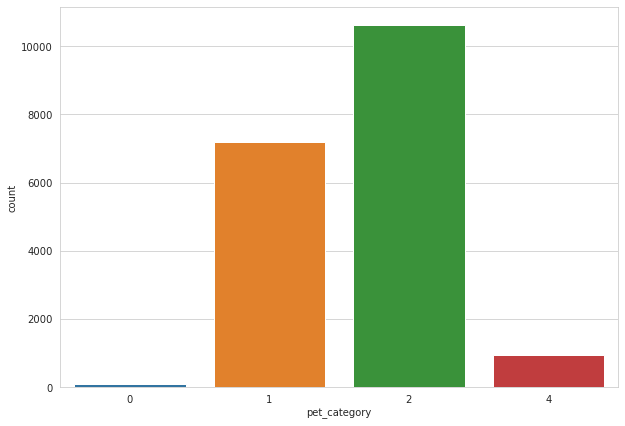

In [12]:
plt.figure(figsize=(10,7))
sns.countplot(labels['pet_category'])

In [13]:
df_all['isd_date'] = df_all['isd_date'].astype('int64')
df_all['lst_date'] = df_all['lst_date'].astype('int64')

In [14]:
df_all.head()

,condition,color_type,length(m),height(cm),X1,X2,isd_date,isd_month,isd_year,lst_date,lst_month,lst_year
0,2.0,Brown Tabby,0.80,7.78,13,9,10,07,2016,21,09,2016
1,1.0,White,0.72,14.19,13,9,21,11,2013,27,12,2018
2,NaN,Brown,0.15,40.90,15,4,28,09,2014,19,10,2016
3,1.0,White,0.62,17.82,0,1,31,12,2016,25,01,2019
4,2.0,Black,0.50,11.06,18,4,28,09,2017,19,11,2017


In [15]:
def value_counts(df):
    a = {}
    for column in df.columns:
        a[column] = len(df[column].value_counts())
    return a

In [16]:
def Categorical(df):
    categories = []
    for column in df.columns:
        if df[column].dtype =='object' or len(df[column].value_counts()) < 32:
            categories.append(column)
    return categories

In [17]:
df_all['isd_month'] = df_all['isd_month'].astype('int')
df_all['lst_month'] = df_all['lst_month'].astype('int')

In [18]:
def month_to_date(n):
    total = 0
    memo = {1:31,2:28,3:31,4:30}
    memo[6] = memo[9] = memo[11] = memo[4]
    memo[5] = memo[7] = memo[8] = memo[10] = memo[12] = memo[1]
    
    for i in range(1,n+1):
        total = total+memo[i]
    return total

In [19]:
df_all['monthindate'] = df_all['isd_month'].apply(month_to_date)
df_all['isd D-M'] = df_all['monthindate']+df_all['isd_date']
df_all.drop('monthindate',axis=1,inplace=True)


df_all['monthindate'] = df_all['lst_month'].apply(month_to_date)
df_all['lst D-M'] = df_all['monthindate']+df_all['lst_date']
df_all.drop('monthindate',axis=1,inplace=True)

In [20]:
df_all['length(cm)'] = df_all['length(m)'].apply(lambda x:x*100)
df_all['area'] = df_all['length(cm)']*df_all['height(cm)']

df_all['X1+X2'] = df_all['X1']+df_all['X2']

In [21]:
df_all.head()

,condition,color_type,length(m),height(cm),X1,X2,isd_date,isd_month,isd_year,lst_date,lst_month,lst_year,isd D-M,lst D-M,length(cm),area,X1+X2
0,2.0,Brown Tabby,0.80,7.78,13,9,10,7,2016,21,9,2016,222,294,80.0,622.40,22
1,1.0,White,0.72,14.19,13,9,21,11,2013,27,12,2018,355,392,72.0,1021.68,22
2,NaN,Brown,0.15,40.90,15,4,28,9,2014,19,10,2016,301,323,15.0,613.50,19
3,1.0,White,0.62,17.82,0,1,31,12,2016,25,1,2019,396,56,62.0,1104.84,1
4,2.0,Black,0.50,11.06,18,4,28,9,2017,19,11,2017,301,353,50.0,553.00,22


In [22]:
onehot = pd.get_dummies(df_all['color_type'],drop_first=True)
df_all.drop('color_type',axis=1,inplace=True)
df_all = pd.concat([df_all,onehot],axis=1)

In [23]:
df_all.head()

,condition,length(m),height(cm),X1,X2,isd_date,isd_month,isd_year,lst_date,lst_month,...,Silver Lynx Point,Silver Tabby,Tan,Torbie,Tortie,Tortie Point,Tricolor,White,Yellow,Yellow Brindle
0,2.0,0.80,7.78,13,9,10,7,2016,21,9,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.72,14.19,13,9,21,11,2013,27,12,...,0,0,0,0,0,0,0,1,0,0
2,NaN,0.15,40.90,15,4,28,9,2014,19,10,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.62,17.82,0,1,31,12,2016,25,1,...,0,0,0,0,0,0,0,1,0,0
4,2.0,0.50,11.06,18,4,28,9,2017,19,11,...,0,0,0,0,0,0,0,0,0,0


In [24]:
for column in df_all.columns:
    if df_all[column].dtype != 'int64' and df_all[column].dtype != 'float64':
        df_all[column] = df_all[column].astype('int64')

In [27]:
train = df_all.iloc[0:len(df_train),:]
test = df_all.iloc[len(df_train):,:]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train, labels,test_size=0.2,stratify=labels,random_state=0)

In [29]:
def total_score(f1,f2):
    score = 100*(f1+f2)/2
    return score

In [30]:
y_clf1 = y_train.iloc[:,0] 
y_clf2 = y_train.iloc[:,1]

X_clf2 = np.concatenate([X_train,y_clf1.values.reshape(-1,1)],axis=1)

def clf2_predict(X):
    return np.concatenate([X_test,X.reshape(-1,1)],axis=1)

In [31]:
xgb1 = XGBClassifier()
xgb1.fit(X_train,y_clf1)

y_pred_xgb1 = xgb1.predict(X_test)
f1 = metrics.f1_score(y_test.iloc[:,0],y_pred_xgb1,average='weighted')


xgb2 = XGBClassifier()
xgb2.fit(X_clf2,y_clf2)

y_pred_xgb2 = xgb2.predict(clf2_predict(y_pred_xgb1))
f2 = metrics.f1_score(y_test.iloc[:,1],y_pred_xgb2,average='weighted')

In [32]:
print(f1,f2)
print(total_score(f1,f2))

0.9006676898082988 0.905597456999826
90.31325734040624


In [33]:
lgb1 = LGBMClassifier()
lgb1.fit(X_train,y_clf1)

y_pred_lgb1 = lgb1.predict(X_test)
lgb_f1 = metrics.f1_score(y_test.iloc[:,0],y_pred_lgb1,average='weighted')


lgb2 = LGBMClassifier()
lgb2.fit(X_clf2,y_clf2)

y_pred_lgb2 = lgb2.predict(clf2_predict(y_pred_lgb1))
lgb_f2 = metrics.f1_score(y_test.iloc[:,1],y_pred_lgb2,average='weighted')

In [34]:
print(lgb_f1,lgb_f2)
print(total_score(lgb_f1,lgb_f2))

0.8980047855048117 0.9033390239075515
90.06719047061816


In [37]:
cv = StratifiedKFold(n_splits=4)
f1 = cross_val_score(lgb1,X_train,y_clf1,scoring='f1_weighted',cv=cv)
f2 = cross_val_score(lgb2,X_clf2,y_clf2,scoring='f1_weighted',cv=cv)

In [38]:
print(f1,f2)
print(f1.mean(),f1.std())
print(f2.mean(),f2.std())

[0.90943109 0.90410222 0.89879985 0.89936163] [0.89454745 0.89575029 0.88512916 0.89775998]
0.9029236987719402 0.004284549559554476
0.8932967197068671 0.0048531959348003875


In [39]:
total_score(f1.mean(),f2.mean())

89.81102092394036

In [40]:
cb1 = CatBoostClassifier()
cb1.fit(X_train,y_clf1)

y_pred_cb1 = cb1.predict(X_test)
cb_f1 = metrics.f1_score(y_test.iloc[:,0],y_pred_cb1,average='weighted')


cb2 = CatBoostClassifier()
cb2.fit(X_clf2,y_clf2)

y_pred_cb2 = cb2.predict(clf2_predict(y_pred_cb1))
cb_f2 = metrics.f1_score(y_test.iloc[:,1],y_pred_cb2,average='weighted')

Learning rate set to 0.090866
0:	learn: 0.9560358	total: 73ms	remaining: 1m 12s
1:	learn: 0.8464549	total: 83.8ms	remaining: 41.8s
2:	learn: 0.7577450	total: 95.1ms	remaining: 31.6s
3:	learn: 0.6846575	total: 106ms	remaining: 26.3s
4:	learn: 0.6234465	total: 117ms	remaining: 23.3s
5:	learn: 0.5709047	total: 126ms	remaining: 20.9s
6:	learn: 0.5260146	total: 139ms	remaining: 19.7s
7:	learn: 0.4869347	total: 158ms	remaining: 19.6s
8:	learn: 0.4529806	total: 172ms	remaining: 18.9s
9:	learn: 0.4229627	total: 184ms	remaining: 18.2s
10:	learn: 0.3961169	total: 197ms	remaining: 17.7s
11:	learn: 0.3726776	total: 208ms	remaining: 17.1s
12:	learn: 0.3518671	total: 219ms	remaining: 16.7s
13:	learn: 0.3329000	total: 230ms	remaining: 16.2s
14:	learn: 0.3162899	total: 242ms	remaining: 15.9s
15:	learn: 0.3008864	total: 252ms	remaining: 15.5s
16:	learn: 0.2869410	total: 263ms	remaining: 15.2s
17:	learn: 0.2747676	total: 274ms	remaining: 14.9s
18:	learn: 0.2649276	total: 284ms	remaining: 14.7s
19:	learn

168:	learn: 0.1389786	total: 2.03s	remaining: 10s
169:	learn: 0.1389293	total: 2.04s	remaining: 9.98s
170:	learn: 0.1387838	total: 2.05s	remaining: 9.96s
171:	learn: 0.1387070	total: 2.06s	remaining: 9.94s
172:	learn: 0.1386166	total: 2.08s	remaining: 9.92s
173:	learn: 0.1385207	total: 2.09s	remaining: 9.9s
174:	learn: 0.1384381	total: 2.1s	remaining: 9.89s
175:	learn: 0.1383758	total: 2.11s	remaining: 9.86s
176:	learn: 0.1382999	total: 2.12s	remaining: 9.84s
177:	learn: 0.1381226	total: 2.13s	remaining: 9.82s
178:	learn: 0.1380291	total: 2.14s	remaining: 9.8s
179:	learn: 0.1378957	total: 2.15s	remaining: 9.78s
180:	learn: 0.1378601	total: 2.16s	remaining: 9.76s
181:	learn: 0.1378475	total: 2.17s	remaining: 9.74s
182:	learn: 0.1377890	total: 2.18s	remaining: 9.72s
183:	learn: 0.1377120	total: 2.19s	remaining: 9.7s
184:	learn: 0.1375674	total: 2.2s	remaining: 9.7s
185:	learn: 0.1375089	total: 2.21s	remaining: 9.69s
186:	learn: 0.1373361	total: 2.22s	remaining: 9.66s
187:	learn: 0.137197

342:	learn: 0.1242777	total: 3.86s	remaining: 7.39s
343:	learn: 0.1242264	total: 3.87s	remaining: 7.38s
344:	learn: 0.1241629	total: 3.88s	remaining: 7.37s
345:	learn: 0.1241541	total: 3.89s	remaining: 7.35s
346:	learn: 0.1240959	total: 3.9s	remaining: 7.34s
347:	learn: 0.1240611	total: 3.91s	remaining: 7.33s
348:	learn: 0.1239573	total: 3.92s	remaining: 7.31s
349:	learn: 0.1239084	total: 3.93s	remaining: 7.3s
350:	learn: 0.1238391	total: 3.94s	remaining: 7.29s
351:	learn: 0.1237726	total: 3.95s	remaining: 7.27s
352:	learn: 0.1237268	total: 3.96s	remaining: 7.26s
353:	learn: 0.1236729	total: 3.97s	remaining: 7.25s
354:	learn: 0.1235229	total: 3.98s	remaining: 7.24s
355:	learn: 0.1234384	total: 3.99s	remaining: 7.22s
356:	learn: 0.1234013	total: 4s	remaining: 7.21s
357:	learn: 0.1233811	total: 4.01s	remaining: 7.2s
358:	learn: 0.1233189	total: 4.02s	remaining: 7.19s
359:	learn: 0.1232472	total: 4.04s	remaining: 7.17s
360:	learn: 0.1231994	total: 4.04s	remaining: 7.16s
361:	learn: 0.1231

501:	learn: 0.1142921	total: 5.49s	remaining: 5.44s
502:	learn: 0.1142804	total: 5.5s	remaining: 5.43s
503:	learn: 0.1142656	total: 5.51s	remaining: 5.42s
504:	learn: 0.1142432	total: 5.51s	remaining: 5.41s
505:	learn: 0.1142071	total: 5.53s	remaining: 5.39s
506:	learn: 0.1141238	total: 5.54s	remaining: 5.38s
507:	learn: 0.1141053	total: 5.54s	remaining: 5.37s
508:	learn: 0.1140821	total: 5.55s	remaining: 5.36s
509:	learn: 0.1139804	total: 5.57s	remaining: 5.35s
510:	learn: 0.1139290	total: 5.57s	remaining: 5.33s
511:	learn: 0.1138802	total: 5.58s	remaining: 5.32s
512:	learn: 0.1138303	total: 5.59s	remaining: 5.31s
513:	learn: 0.1138028	total: 5.61s	remaining: 5.3s
514:	learn: 0.1137315	total: 5.62s	remaining: 5.29s
515:	learn: 0.1136431	total: 5.63s	remaining: 5.28s
516:	learn: 0.1136004	total: 5.64s	remaining: 5.27s
517:	learn: 0.1135774	total: 5.65s	remaining: 5.25s
518:	learn: 0.1134168	total: 5.66s	remaining: 5.24s
519:	learn: 0.1133924	total: 5.67s	remaining: 5.23s
520:	learn: 0.

660:	learn: 0.1059550	total: 7.13s	remaining: 3.65s
661:	learn: 0.1059208	total: 7.14s	remaining: 3.64s
662:	learn: 0.1058676	total: 7.15s	remaining: 3.63s
663:	learn: 0.1058259	total: 7.16s	remaining: 3.62s
664:	learn: 0.1057685	total: 7.17s	remaining: 3.61s
665:	learn: 0.1057193	total: 7.18s	remaining: 3.6s
666:	learn: 0.1056738	total: 7.19s	remaining: 3.59s
667:	learn: 0.1056349	total: 7.2s	remaining: 3.58s
668:	learn: 0.1056166	total: 7.21s	remaining: 3.57s
669:	learn: 0.1055398	total: 7.22s	remaining: 3.56s
670:	learn: 0.1054762	total: 7.23s	remaining: 3.54s
671:	learn: 0.1054289	total: 7.24s	remaining: 3.53s
672:	learn: 0.1054110	total: 7.25s	remaining: 3.52s
673:	learn: 0.1053240	total: 7.26s	remaining: 3.51s
674:	learn: 0.1052613	total: 7.27s	remaining: 3.5s
675:	learn: 0.1052271	total: 7.28s	remaining: 3.49s
676:	learn: 0.1051871	total: 7.29s	remaining: 3.48s
677:	learn: 0.1051021	total: 7.3s	remaining: 3.47s
678:	learn: 0.1050444	total: 7.31s	remaining: 3.46s
679:	learn: 0.10

819:	learn: 0.0984494	total: 8.77s	remaining: 1.92s
820:	learn: 0.0983990	total: 8.78s	remaining: 1.91s
821:	learn: 0.0983695	total: 8.79s	remaining: 1.9s
822:	learn: 0.0982927	total: 8.8s	remaining: 1.89s
823:	learn: 0.0982456	total: 8.81s	remaining: 1.88s
824:	learn: 0.0982014	total: 8.82s	remaining: 1.87s
825:	learn: 0.0981271	total: 8.83s	remaining: 1.86s
826:	learn: 0.0980767	total: 8.84s	remaining: 1.85s
827:	learn: 0.0980141	total: 8.85s	remaining: 1.84s
828:	learn: 0.0979840	total: 8.86s	remaining: 1.83s
829:	learn: 0.0979521	total: 8.87s	remaining: 1.82s
830:	learn: 0.0979446	total: 8.88s	remaining: 1.81s
831:	learn: 0.0978946	total: 8.89s	remaining: 1.79s
832:	learn: 0.0978344	total: 8.9s	remaining: 1.78s
833:	learn: 0.0978069	total: 8.91s	remaining: 1.77s
834:	learn: 0.0977321	total: 8.92s	remaining: 1.76s
835:	learn: 0.0976763	total: 8.93s	remaining: 1.75s
836:	learn: 0.0976457	total: 8.94s	remaining: 1.74s
837:	learn: 0.0976327	total: 8.95s	remaining: 1.73s
838:	learn: 0.0

984:	learn: 0.0919504	total: 10.6s	remaining: 162ms
985:	learn: 0.0918717	total: 10.6s	remaining: 151ms
986:	learn: 0.0918300	total: 10.6s	remaining: 140ms
987:	learn: 0.0917472	total: 10.6s	remaining: 129ms
988:	learn: 0.0917056	total: 10.7s	remaining: 118ms
989:	learn: 0.0916627	total: 10.7s	remaining: 108ms
990:	learn: 0.0916463	total: 10.7s	remaining: 97ms
991:	learn: 0.0916064	total: 10.7s	remaining: 86.2ms
992:	learn: 0.0915340	total: 10.7s	remaining: 75.4ms
993:	learn: 0.0915157	total: 10.7s	remaining: 64.6ms
994:	learn: 0.0914892	total: 10.7s	remaining: 53.9ms
995:	learn: 0.0914430	total: 10.7s	remaining: 43.1ms
996:	learn: 0.0914320	total: 10.7s	remaining: 32.3ms
997:	learn: 0.0914008	total: 10.8s	remaining: 21.5ms
998:	learn: 0.0913444	total: 10.8s	remaining: 10.8ms
999:	learn: 0.0912850	total: 10.8s	remaining: 0us
Learning rate set to 0.090866
0:	learn: 1.2441399	total: 15.1ms	remaining: 15s
1:	learn: 1.1328603	total: 28.4ms	remaining: 14.2s
2:	learn: 1.0417691	total: 40.1ms

148:	learn: 0.2926873	total: 1.82s	remaining: 10.4s
149:	learn: 0.2924275	total: 1.83s	remaining: 10.4s
150:	learn: 0.2920753	total: 1.84s	remaining: 10.4s
151:	learn: 0.2916880	total: 1.86s	remaining: 10.4s
152:	learn: 0.2911585	total: 1.87s	remaining: 10.4s
153:	learn: 0.2907588	total: 1.88s	remaining: 10.3s
154:	learn: 0.2901062	total: 1.89s	remaining: 10.3s
155:	learn: 0.2897299	total: 1.9s	remaining: 10.3s
156:	learn: 0.2893923	total: 1.91s	remaining: 10.3s
157:	learn: 0.2889304	total: 1.92s	remaining: 10.2s
158:	learn: 0.2881335	total: 1.94s	remaining: 10.2s
159:	learn: 0.2874106	total: 1.95s	remaining: 10.2s
160:	learn: 0.2869329	total: 1.96s	remaining: 10.2s
161:	learn: 0.2862449	total: 1.97s	remaining: 10.2s
162:	learn: 0.2859666	total: 1.98s	remaining: 10.2s
163:	learn: 0.2856705	total: 1.99s	remaining: 10.2s
164:	learn: 0.2851408	total: 2s	remaining: 10.1s
165:	learn: 0.2846167	total: 2.02s	remaining: 10.1s
166:	learn: 0.2844711	total: 2.02s	remaining: 10.1s
167:	learn: 0.28

308:	learn: 0.2499725	total: 3.65s	remaining: 8.17s
309:	learn: 0.2498165	total: 3.67s	remaining: 8.16s
310:	learn: 0.2496379	total: 3.68s	remaining: 8.15s
311:	learn: 0.2493939	total: 3.69s	remaining: 8.14s
312:	learn: 0.2491444	total: 3.71s	remaining: 8.13s
313:	learn: 0.2489940	total: 3.72s	remaining: 8.12s
314:	learn: 0.2488091	total: 3.73s	remaining: 8.11s
315:	learn: 0.2486684	total: 3.74s	remaining: 8.1s
316:	learn: 0.2485686	total: 3.75s	remaining: 8.08s
317:	learn: 0.2483351	total: 3.76s	remaining: 8.07s
318:	learn: 0.2480188	total: 3.77s	remaining: 8.06s
319:	learn: 0.2478320	total: 3.79s	remaining: 8.05s
320:	learn: 0.2476666	total: 3.8s	remaining: 8.04s
321:	learn: 0.2475288	total: 3.81s	remaining: 8.02s
322:	learn: 0.2473126	total: 3.82s	remaining: 8.01s
323:	learn: 0.2471925	total: 3.83s	remaining: 8s
324:	learn: 0.2471247	total: 3.84s	remaining: 7.98s
325:	learn: 0.2470648	total: 3.85s	remaining: 7.96s
326:	learn: 0.2468666	total: 3.87s	remaining: 7.96s
327:	learn: 0.246

476:	learn: 0.2212601	total: 5.69s	remaining: 6.24s
477:	learn: 0.2211923	total: 5.7s	remaining: 6.22s
478:	learn: 0.2209813	total: 5.71s	remaining: 6.21s
479:	learn: 0.2207132	total: 5.72s	remaining: 6.2s
480:	learn: 0.2204356	total: 5.74s	remaining: 6.19s
481:	learn: 0.2202209	total: 5.75s	remaining: 6.18s
482:	learn: 0.2200518	total: 5.76s	remaining: 6.17s
483:	learn: 0.2198304	total: 5.78s	remaining: 6.16s
484:	learn: 0.2196962	total: 5.79s	remaining: 6.14s
485:	learn: 0.2195783	total: 5.8s	remaining: 6.13s
486:	learn: 0.2194479	total: 5.81s	remaining: 6.12s
487:	learn: 0.2192963	total: 5.83s	remaining: 6.11s
488:	learn: 0.2192097	total: 5.84s	remaining: 6.1s
489:	learn: 0.2190947	total: 5.85s	remaining: 6.09s
490:	learn: 0.2190065	total: 5.86s	remaining: 6.07s
491:	learn: 0.2189150	total: 5.87s	remaining: 6.06s
492:	learn: 0.2187308	total: 5.88s	remaining: 6.05s
493:	learn: 0.2186819	total: 5.9s	remaining: 6.04s
494:	learn: 0.2185848	total: 5.91s	remaining: 6.03s
495:	learn: 0.218

646:	learn: 0.1987711	total: 7.74s	remaining: 4.22s
647:	learn: 0.1985512	total: 7.75s	remaining: 4.21s
648:	learn: 0.1984991	total: 7.76s	remaining: 4.2s
649:	learn: 0.1984024	total: 7.78s	remaining: 4.19s
650:	learn: 0.1983636	total: 7.79s	remaining: 4.17s
651:	learn: 0.1982513	total: 7.8s	remaining: 4.16s
652:	learn: 0.1981883	total: 7.81s	remaining: 4.15s
653:	learn: 0.1980284	total: 7.82s	remaining: 4.14s
654:	learn: 0.1979334	total: 7.83s	remaining: 4.13s
655:	learn: 0.1978455	total: 7.85s	remaining: 4.11s
656:	learn: 0.1977791	total: 7.86s	remaining: 4.1s
657:	learn: 0.1975328	total: 7.87s	remaining: 4.09s
658:	learn: 0.1974271	total: 7.88s	remaining: 4.08s
659:	learn: 0.1972818	total: 7.9s	remaining: 4.07s
660:	learn: 0.1971329	total: 7.91s	remaining: 4.06s
661:	learn: 0.1970755	total: 7.92s	remaining: 4.04s
662:	learn: 0.1968713	total: 7.93s	remaining: 4.03s
663:	learn: 0.1967609	total: 7.95s	remaining: 4.02s
664:	learn: 0.1966810	total: 7.96s	remaining: 4.01s
665:	learn: 0.19

810:	learn: 0.1814491	total: 9.77s	remaining: 2.28s
811:	learn: 0.1812975	total: 9.79s	remaining: 2.27s
812:	learn: 0.1812277	total: 9.8s	remaining: 2.25s
813:	learn: 0.1811497	total: 9.81s	remaining: 2.24s
814:	learn: 0.1810840	total: 9.82s	remaining: 2.23s
815:	learn: 0.1809424	total: 9.83s	remaining: 2.22s
816:	learn: 0.1808773	total: 9.84s	remaining: 2.2s
817:	learn: 0.1806861	total: 9.86s	remaining: 2.19s
818:	learn: 0.1806338	total: 9.87s	remaining: 2.18s
819:	learn: 0.1805272	total: 9.88s	remaining: 2.17s
820:	learn: 0.1804658	total: 9.89s	remaining: 2.16s
821:	learn: 0.1803643	total: 9.9s	remaining: 2.14s
822:	learn: 0.1802155	total: 9.91s	remaining: 2.13s
823:	learn: 0.1800935	total: 9.93s	remaining: 2.12s
824:	learn: 0.1799299	total: 9.94s	remaining: 2.11s
825:	learn: 0.1798243	total: 9.95s	remaining: 2.1s
826:	learn: 0.1797189	total: 9.97s	remaining: 2.08s
827:	learn: 0.1796910	total: 9.98s	remaining: 2.07s
828:	learn: 0.1796265	total: 9.99s	remaining: 2.06s
829:	learn: 0.17

970:	learn: 0.1658403	total: 11.8s	remaining: 354ms
971:	learn: 0.1657212	total: 11.8s	remaining: 341ms
972:	learn: 0.1656877	total: 11.9s	remaining: 329ms
973:	learn: 0.1656324	total: 11.9s	remaining: 317ms
974:	learn: 0.1655876	total: 11.9s	remaining: 305ms
975:	learn: 0.1655697	total: 11.9s	remaining: 293ms
976:	learn: 0.1655048	total: 11.9s	remaining: 280ms
977:	learn: 0.1654320	total: 11.9s	remaining: 268ms
978:	learn: 0.1652786	total: 11.9s	remaining: 256ms
979:	learn: 0.1651332	total: 11.9s	remaining: 244ms
980:	learn: 0.1650879	total: 12s	remaining: 232ms
981:	learn: 0.1649265	total: 12s	remaining: 219ms
982:	learn: 0.1648405	total: 12s	remaining: 207ms
983:	learn: 0.1647854	total: 12s	remaining: 195ms
984:	learn: 0.1647363	total: 12s	remaining: 183ms
985:	learn: 0.1646811	total: 12s	remaining: 171ms
986:	learn: 0.1646175	total: 12s	remaining: 158ms
987:	learn: 0.1645675	total: 12s	remaining: 146ms
988:	learn: 0.1644043	total: 12.1s	remaining: 134ms
989:	learn: 0.1643334	total:

In [41]:
print(cb_f1,cb_f2)
print(total_score(cb_f1,cb_f2))

0.9004385420738675 0.9028992106747413
90.16688763743043


In [43]:
vot_clf = VotingClassifier(estimators=[('xgboost',xgb1),
                                       ('lgb',lgb1),
                                       ('cb',cb1)], voting='soft')
vot_clf.fit(X_train,y_clf1)

y_pred_vot1 = vot_clf.predict(X_test)
vot_f1 = metrics.f1_score(y_test.iloc[:,0],y_pred_vot1,average='weighted')


vot_clf2 = VotingClassifier(estimators=[('xgboost',xgb2),
                                        ('lgb',lgb2),
                                        ('cb',cb1)], voting='soft')
vot_clf2.fit(X_clf2,y_clf2)

y_pred_vot2 = vot_clf2.predict(clf2_predict(y_pred_vot1))
vot_f2 = metrics.f1_score(y_test.iloc[:,1],y_pred_vot2,average='weighted')

Learning rate set to 0.090866
0:	learn: 0.9560358	total: 19.6ms	remaining: 19.6s
1:	learn: 0.8464549	total: 38.5ms	remaining: 19.2s
2:	learn: 0.7577450	total: 58.7ms	remaining: 19.5s
3:	learn: 0.6846575	total: 77.4ms	remaining: 19.3s
4:	learn: 0.6234465	total: 97ms	remaining: 19.3s
5:	learn: 0.5709047	total: 115ms	remaining: 19s
6:	learn: 0.5260146	total: 131ms	remaining: 18.6s
7:	learn: 0.4869347	total: 141ms	remaining: 17.5s
8:	learn: 0.4529806	total: 153ms	remaining: 16.8s
9:	learn: 0.4229627	total: 168ms	remaining: 16.7s
10:	learn: 0.3961169	total: 183ms	remaining: 16.4s
11:	learn: 0.3726776	total: 195ms	remaining: 16.1s
12:	learn: 0.3518671	total: 206ms	remaining: 15.7s
13:	learn: 0.3329000	total: 217ms	remaining: 15.3s
14:	learn: 0.3162899	total: 230ms	remaining: 15.1s
15:	learn: 0.3008864	total: 242ms	remaining: 14.9s
16:	learn: 0.2869410	total: 254ms	remaining: 14.7s
17:	learn: 0.2747676	total: 265ms	remaining: 14.5s
18:	learn: 0.2649276	total: 276ms	remaining: 14.3s
19:	learn:

161:	learn: 0.1395508	total: 1.81s	remaining: 9.37s
162:	learn: 0.1393592	total: 1.82s	remaining: 9.35s
163:	learn: 0.1393390	total: 1.83s	remaining: 9.34s
164:	learn: 0.1392635	total: 1.84s	remaining: 9.32s
165:	learn: 0.1391903	total: 1.86s	remaining: 9.33s
166:	learn: 0.1391377	total: 1.87s	remaining: 9.35s
167:	learn: 0.1391098	total: 1.89s	remaining: 9.37s
168:	learn: 0.1389786	total: 1.91s	remaining: 9.38s
169:	learn: 0.1389293	total: 1.93s	remaining: 9.41s
170:	learn: 0.1387838	total: 1.95s	remaining: 9.45s
171:	learn: 0.1387070	total: 1.97s	remaining: 9.46s
172:	learn: 0.1386166	total: 1.99s	remaining: 9.49s
173:	learn: 0.1385207	total: 2s	remaining: 9.5s
174:	learn: 0.1384381	total: 2.02s	remaining: 9.54s
175:	learn: 0.1383758	total: 2.04s	remaining: 9.54s
176:	learn: 0.1382999	total: 2.05s	remaining: 9.52s
177:	learn: 0.1381226	total: 2.06s	remaining: 9.49s
178:	learn: 0.1380291	total: 2.07s	remaining: 9.48s
179:	learn: 0.1378957	total: 2.08s	remaining: 9.46s
180:	learn: 0.13

331:	learn: 0.1250479	total: 3.66s	remaining: 7.37s
332:	learn: 0.1250122	total: 3.67s	remaining: 7.36s
333:	learn: 0.1249848	total: 3.68s	remaining: 7.34s
334:	learn: 0.1248648	total: 3.69s	remaining: 7.33s
335:	learn: 0.1247800	total: 3.7s	remaining: 7.32s
336:	learn: 0.1247040	total: 3.71s	remaining: 7.31s
337:	learn: 0.1246549	total: 3.72s	remaining: 7.29s
338:	learn: 0.1245994	total: 3.73s	remaining: 7.28s
339:	learn: 0.1245080	total: 3.75s	remaining: 7.27s
340:	learn: 0.1244383	total: 3.76s	remaining: 7.26s
341:	learn: 0.1243914	total: 3.77s	remaining: 7.25s
342:	learn: 0.1242777	total: 3.78s	remaining: 7.24s
343:	learn: 0.1242264	total: 3.79s	remaining: 7.22s
344:	learn: 0.1241629	total: 3.8s	remaining: 7.21s
345:	learn: 0.1241541	total: 3.81s	remaining: 7.2s
346:	learn: 0.1240959	total: 3.82s	remaining: 7.18s
347:	learn: 0.1240611	total: 3.83s	remaining: 7.17s
348:	learn: 0.1239573	total: 3.84s	remaining: 7.16s
349:	learn: 0.1239084	total: 3.85s	remaining: 7.15s
350:	learn: 0.1

504:	learn: 0.1142432	total: 5.48s	remaining: 5.37s
505:	learn: 0.1142071	total: 5.49s	remaining: 5.36s
506:	learn: 0.1141238	total: 5.5s	remaining: 5.35s
507:	learn: 0.1141053	total: 5.51s	remaining: 5.34s
508:	learn: 0.1140821	total: 5.52s	remaining: 5.33s
509:	learn: 0.1139804	total: 5.53s	remaining: 5.32s
510:	learn: 0.1139290	total: 5.54s	remaining: 5.3s
511:	learn: 0.1138802	total: 5.55s	remaining: 5.29s
512:	learn: 0.1138303	total: 5.57s	remaining: 5.28s
513:	learn: 0.1138028	total: 5.58s	remaining: 5.28s
514:	learn: 0.1137315	total: 5.59s	remaining: 5.26s
515:	learn: 0.1136431	total: 5.6s	remaining: 5.25s
516:	learn: 0.1136004	total: 5.61s	remaining: 5.24s
517:	learn: 0.1135774	total: 5.62s	remaining: 5.23s
518:	learn: 0.1134168	total: 5.63s	remaining: 5.22s
519:	learn: 0.1133924	total: 5.64s	remaining: 5.21s
520:	learn: 0.1133406	total: 5.65s	remaining: 5.2s
521:	learn: 0.1132905	total: 5.67s	remaining: 5.19s
522:	learn: 0.1131813	total: 5.68s	remaining: 5.18s
523:	learn: 0.11

673:	learn: 0.1053240	total: 7.3s	remaining: 3.53s
674:	learn: 0.1052613	total: 7.31s	remaining: 3.52s
675:	learn: 0.1052271	total: 7.32s	remaining: 3.51s
676:	learn: 0.1051871	total: 7.33s	remaining: 3.5s
677:	learn: 0.1051021	total: 7.34s	remaining: 3.48s
678:	learn: 0.1050444	total: 7.35s	remaining: 3.47s
679:	learn: 0.1049952	total: 7.36s	remaining: 3.46s
680:	learn: 0.1049654	total: 7.37s	remaining: 3.45s
681:	learn: 0.1048912	total: 7.38s	remaining: 3.44s
682:	learn: 0.1047634	total: 7.39s	remaining: 3.43s
683:	learn: 0.1047029	total: 7.4s	remaining: 3.42s
684:	learn: 0.1046803	total: 7.41s	remaining: 3.41s
685:	learn: 0.1046396	total: 7.42s	remaining: 3.4s
686:	learn: 0.1045887	total: 7.43s	remaining: 3.39s
687:	learn: 0.1045586	total: 7.44s	remaining: 3.37s
688:	learn: 0.1045244	total: 7.45s	remaining: 3.36s
689:	learn: 0.1044337	total: 7.46s	remaining: 3.35s
690:	learn: 0.1043597	total: 7.47s	remaining: 3.34s
691:	learn: 0.1043127	total: 7.49s	remaining: 3.33s
692:	learn: 0.10

846:	learn: 0.0972656	total: 9.11s	remaining: 1.65s
847:	learn: 0.0972467	total: 9.12s	remaining: 1.64s
848:	learn: 0.0972179	total: 9.13s	remaining: 1.62s
849:	learn: 0.0971639	total: 9.14s	remaining: 1.61s
850:	learn: 0.0971294	total: 9.15s	remaining: 1.6s
851:	learn: 0.0970960	total: 9.16s	remaining: 1.59s
852:	learn: 0.0970474	total: 9.17s	remaining: 1.58s
853:	learn: 0.0969953	total: 9.19s	remaining: 1.57s
854:	learn: 0.0969716	total: 9.2s	remaining: 1.56s
855:	learn: 0.0969433	total: 9.21s	remaining: 1.55s
856:	learn: 0.0968549	total: 9.22s	remaining: 1.54s
857:	learn: 0.0968041	total: 9.23s	remaining: 1.53s
858:	learn: 0.0967947	total: 9.24s	remaining: 1.52s
859:	learn: 0.0967477	total: 9.25s	remaining: 1.5s
860:	learn: 0.0967041	total: 9.26s	remaining: 1.49s
861:	learn: 0.0966796	total: 9.27s	remaining: 1.48s
862:	learn: 0.0966585	total: 9.28s	remaining: 1.47s
863:	learn: 0.0966105	total: 9.29s	remaining: 1.46s
864:	learn: 0.0965494	total: 9.3s	remaining: 1.45s
865:	learn: 0.09

11:	learn: 0.6442515	total: 199ms	remaining: 16.4s
12:	learn: 0.6195238	total: 210ms	remaining: 15.9s
13:	learn: 0.5964722	total: 222ms	remaining: 15.7s
14:	learn: 0.5769331	total: 233ms	remaining: 15.3s
15:	learn: 0.5594603	total: 244ms	remaining: 15s
16:	learn: 0.5452099	total: 258ms	remaining: 14.9s
17:	learn: 0.5318917	total: 271ms	remaining: 14.8s
18:	learn: 0.5182659	total: 281ms	remaining: 14.5s
19:	learn: 0.5079819	total: 294ms	remaining: 14.4s
20:	learn: 0.4973970	total: 304ms	remaining: 14.2s
21:	learn: 0.4878215	total: 316ms	remaining: 14s
22:	learn: 0.4758530	total: 327ms	remaining: 13.9s
23:	learn: 0.4660711	total: 338ms	remaining: 13.7s
24:	learn: 0.4585034	total: 348ms	remaining: 13.6s
25:	learn: 0.4512729	total: 359ms	remaining: 13.4s
26:	learn: 0.4451671	total: 370ms	remaining: 13.3s
27:	learn: 0.4370114	total: 382ms	remaining: 13.3s
28:	learn: 0.4315751	total: 393ms	remaining: 13.2s
29:	learn: 0.4268273	total: 408ms	remaining: 13.2s
30:	learn: 0.4226191	total: 421ms	r

181:	learn: 0.2797399	total: 2.25s	remaining: 10.1s
182:	learn: 0.2794449	total: 2.26s	remaining: 10.1s
183:	learn: 0.2790949	total: 2.27s	remaining: 10.1s
184:	learn: 0.2785291	total: 2.29s	remaining: 10.1s
185:	learn: 0.2784177	total: 2.3s	remaining: 10.1s
186:	learn: 0.2781840	total: 2.31s	remaining: 10s
187:	learn: 0.2779178	total: 2.32s	remaining: 10s
188:	learn: 0.2776308	total: 2.33s	remaining: 10s
189:	learn: 0.2773657	total: 2.34s	remaining: 9.99s
190:	learn: 0.2771333	total: 2.35s	remaining: 9.97s
191:	learn: 0.2769128	total: 2.37s	remaining: 9.96s
192:	learn: 0.2766709	total: 2.38s	remaining: 9.95s
193:	learn: 0.2763678	total: 2.39s	remaining: 9.93s
194:	learn: 0.2762079	total: 2.4s	remaining: 9.91s
195:	learn: 0.2755348	total: 2.41s	remaining: 9.89s
196:	learn: 0.2753456	total: 2.42s	remaining: 9.88s
197:	learn: 0.2750219	total: 2.44s	remaining: 9.86s
198:	learn: 0.2748316	total: 2.45s	remaining: 9.85s
199:	learn: 0.2746555	total: 2.46s	remaining: 9.83s
200:	learn: 0.274308

346:	learn: 0.2430992	total: 4.3s	remaining: 8.09s
347:	learn: 0.2429302	total: 4.31s	remaining: 8.08s
348:	learn: 0.2427989	total: 4.33s	remaining: 8.07s
349:	learn: 0.2424483	total: 4.34s	remaining: 8.06s
350:	learn: 0.2423225	total: 4.35s	remaining: 8.05s
351:	learn: 0.2422039	total: 4.37s	remaining: 8.04s
352:	learn: 0.2420079	total: 4.38s	remaining: 8.03s
353:	learn: 0.2417949	total: 4.39s	remaining: 8.02s
354:	learn: 0.2417164	total: 4.41s	remaining: 8.01s
355:	learn: 0.2415336	total: 4.42s	remaining: 7.99s
356:	learn: 0.2412863	total: 4.43s	remaining: 7.98s
357:	learn: 0.2408633	total: 4.44s	remaining: 7.97s
358:	learn: 0.2406735	total: 4.45s	remaining: 7.95s
359:	learn: 0.2405770	total: 4.47s	remaining: 7.94s
360:	learn: 0.2404265	total: 4.48s	remaining: 7.93s
361:	learn: 0.2401220	total: 4.49s	remaining: 7.92s
362:	learn: 0.2398189	total: 4.51s	remaining: 7.91s
363:	learn: 0.2395129	total: 4.52s	remaining: 7.9s
364:	learn: 0.2393894	total: 4.53s	remaining: 7.89s
365:	learn: 0.

510:	learn: 0.2166303	total: 6.36s	remaining: 6.08s
511:	learn: 0.2163617	total: 6.37s	remaining: 6.07s
512:	learn: 0.2162459	total: 6.38s	remaining: 6.06s
513:	learn: 0.2160965	total: 6.39s	remaining: 6.04s
514:	learn: 0.2159567	total: 6.41s	remaining: 6.03s
515:	learn: 0.2157916	total: 6.42s	remaining: 6.02s
516:	learn: 0.2156395	total: 6.43s	remaining: 6.01s
517:	learn: 0.2156130	total: 6.44s	remaining: 5.99s
518:	learn: 0.2153601	total: 6.45s	remaining: 5.98s
519:	learn: 0.2152536	total: 6.46s	remaining: 5.96s
520:	learn: 0.2152071	total: 6.47s	remaining: 5.95s
521:	learn: 0.2150124	total: 6.49s	remaining: 5.94s
522:	learn: 0.2149316	total: 6.5s	remaining: 5.92s
523:	learn: 0.2147894	total: 6.51s	remaining: 5.91s
524:	learn: 0.2146710	total: 6.52s	remaining: 5.9s
525:	learn: 0.2144489	total: 6.54s	remaining: 5.89s
526:	learn: 0.2141860	total: 6.55s	remaining: 5.88s
527:	learn: 0.2141551	total: 6.56s	remaining: 5.87s
528:	learn: 0.2140972	total: 6.57s	remaining: 5.85s
529:	learn: 0.

669:	learn: 0.1958903	total: 8.39s	remaining: 4.13s
670:	learn: 0.1957672	total: 8.4s	remaining: 4.12s
671:	learn: 0.1955539	total: 8.42s	remaining: 4.11s
672:	learn: 0.1953476	total: 8.43s	remaining: 4.09s
673:	learn: 0.1952777	total: 8.44s	remaining: 4.08s
674:	learn: 0.1950734	total: 8.46s	remaining: 4.07s
675:	learn: 0.1949986	total: 8.47s	remaining: 4.06s
676:	learn: 0.1949193	total: 8.48s	remaining: 4.04s
677:	learn: 0.1947512	total: 8.49s	remaining: 4.03s
678:	learn: 0.1947115	total: 8.5s	remaining: 4.02s
679:	learn: 0.1945824	total: 8.52s	remaining: 4.01s
680:	learn: 0.1944888	total: 8.53s	remaining: 4s
681:	learn: 0.1943187	total: 8.54s	remaining: 3.98s
682:	learn: 0.1942851	total: 8.55s	remaining: 3.97s
683:	learn: 0.1942037	total: 8.57s	remaining: 3.96s
684:	learn: 0.1940506	total: 8.58s	remaining: 3.94s
685:	learn: 0.1939582	total: 8.6s	remaining: 3.93s
686:	learn: 0.1937226	total: 8.61s	remaining: 3.92s
687:	learn: 0.1936702	total: 8.62s	remaining: 3.91s
688:	learn: 0.1936

829:	learn: 0.1793959	total: 10.4s	remaining: 2.14s
830:	learn: 0.1792735	total: 10.5s	remaining: 2.13s
831:	learn: 0.1792176	total: 10.5s	remaining: 2.11s
832:	learn: 0.1791417	total: 10.5s	remaining: 2.1s
833:	learn: 0.1790873	total: 10.5s	remaining: 2.09s
834:	learn: 0.1790097	total: 10.5s	remaining: 2.08s
835:	learn: 0.1789250	total: 10.5s	remaining: 2.06s
836:	learn: 0.1787140	total: 10.5s	remaining: 2.05s
837:	learn: 0.1786334	total: 10.5s	remaining: 2.04s
838:	learn: 0.1785446	total: 10.5s	remaining: 2.02s
839:	learn: 0.1784386	total: 10.6s	remaining: 2.01s
840:	learn: 0.1783040	total: 10.6s	remaining: 2s
841:	learn: 0.1781801	total: 10.6s	remaining: 1.99s
842:	learn: 0.1780730	total: 10.6s	remaining: 1.97s
843:	learn: 0.1779663	total: 10.6s	remaining: 1.96s
844:	learn: 0.1778916	total: 10.6s	remaining: 1.95s
845:	learn: 0.1778138	total: 10.6s	remaining: 1.94s
846:	learn: 0.1777618	total: 10.7s	remaining: 1.92s
847:	learn: 0.1776213	total: 10.7s	remaining: 1.91s
848:	learn: 0.17

992:	learn: 0.1639993	total: 12.5s	remaining: 88ms
993:	learn: 0.1639374	total: 12.5s	remaining: 75.4ms
994:	learn: 0.1638776	total: 12.5s	remaining: 62.9ms
995:	learn: 0.1638278	total: 12.5s	remaining: 50.3ms
996:	learn: 0.1637994	total: 12.5s	remaining: 37.7ms
997:	learn: 0.1637163	total: 12.5s	remaining: 25.1ms
998:	learn: 0.1636115	total: 12.6s	remaining: 12.6ms
999:	learn: 0.1635629	total: 12.6s	remaining: 0us


In [44]:
total_score(vot_f1,vot_f2)

90.40106722293146

In [45]:
predictions1 = vot_clf.predict(test)
predictions2 = vot_clf2.predict(np.concatenate([test,predictions1.reshape(-1,1)],axis=1))

In [46]:
sub = pd.DataFrame({
                    "pet_id":id_test,
                    "breed_category":predictions1,
                    "pet_category":predictions2
})

sub.head()

,pet_id,breed_category,pet_category
0,ANSL_75005,1.0,2
1,ANSL_76663,0.0,1
2,ANSL_58259,0.0,2
3,ANSL_67171,0.0,2
4,ANSL_72871,0.0,2


In [47]:
sub['breed_category'] = sub['breed_category'].astype('int64')

In [48]:
sub.to_csv('Submission.csv',index=False)